In [ ]:
import ee
import google.oauth2.credentials
import pywt
import folium

# Trigger the authentication flow.
ee.Authenticate(auth_mode='notebook')

# Initialize the library.
ee.Initialize(project='wavelet-project')


def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# Define the geographical area and filtering criteria
point = ee.Geometry.Point([-99.9018, 41.4925])
region = point.buffer(10000).bounds()
l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')\
        .filterDate('2022-01-01', '2023-12-31')\
        .filterBounds(region)\
        .filter(ee.Filter.lt('CLOUD_COVER', 20))

if l8.size().getInfo() > 0:
    image = l8.first()
    clipped_image = image.clip(region)
    vis_params = {
        'bands': ['B4', 'B3', 'B2'],
        'min': 0,
        'max': 0.5,  # Adjusted for typical scaled TOA reflectance values
        'gamma': 1
    }

    map = folium.Map(location=[41.4925, -99.9018], zoom_start=10)
    map.add_ee_layer(clipped_image, vis_params, "Landsat 8 TOA Image")
    map.add_child(folium.LayerControl())
    display(map) # Explicitly display the map in the notebook
else:
    print("No images found for the specified filters and date range.")

In [3]:
import geopandas as gpd
import ee
ee.Initialize()

# Read the shapefile using Geopandas
gdf = gpd.read_file('training_data_change.shp')

# Function to convert a GeoDataFrame to a FeatureCollection
def geodataframe_to_ee(gdf, ge_column='geometry'):
    features = []
    for _, row in gdf.iterrows():
        geometry = ee.Geometry(row[ge_column].__geo_interface__)
        properties = row.drop(ge_column).to_dict()
        feature = ee.Feature(geometry, properties)
        features.append(feature)
    return ee.FeatureCollection(features)

# Convert the GeoDataFrame to a FeatureCollection
training_shp = geodataframe_to_ee(gdf)

# Continue with your operations here...


In [4]:
import ee
import geemap

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest.
ROI = ee.Geometry.Polygon(
    [[[-74.37518072952373, 41.02358555317697],
      [-74.37518072952373, 40.340423874521555],
      [-73.71600104202373, 40.340423874521555],
      [-73.71600104202373, 41.02358555317697]]])

# Set up date ranges.
before_date_range = ["1989-5-1", "2002-10-01"]
after_date_range = ["2022-5-1", "2023-10-01"]

# Load Landsat imagery.
ls8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
ls5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")

# Function to filter and preprocess images.
def filter_and_scale(img, valid_qa):
    qa_mask = img.select('QA_PIXEL').remap(valid_qa, ee.List.repeat(1, len(valid_qa)), 0)
    img = img.updateMask(qa_mask)
    return img.select('SR_B.*').multiply(0.0000275).add(-0.2)

# Apply functions to image collections.
ls8_processed = ls8.filterDate(*after_date_range).filterBounds(ROI).map(lambda img: filter_and_scale(img, [21824, 21952])).map(lambda img: img.addBands(img.normalizedDifference(['SR_B5', 'SR_B4']).rename('ndvi')))
ls5_processed = ls5.filterDate(*before_date_range).filterBounds(ROI).map(lambda img: filter_and_scale(img, [5440, 5568])).map(lambda img: img.addBands(img.normalizedDifference(['SR_B4', 'SR_B3']).rename('ndvi')))

# Create composite images.
after_img = ls8_processed.qualityMosaic('ndvi').select(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ndvi']).rename(['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'NDVI']).clip(ROI)
before_img = ls5_processed.qualityMosaic('ndvi').select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'ndvi']).rename(['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'NDVI']).clip(ROI)

# Stack images for classification.
multidate_img = ee.Image.cat([before_img, after_img]).rename(['BLUE_b', 'GREEN_b', 'RED_b', 'NIR_b', 'SWIR1_b', 'SWIR2_b', 'NDVI_b', 'BLUE_a', 'GREEN_a', 'RED_a', 'NIR_a', 'SWIR1_a', 'SWIR2_a', 'NDVI_a'])

# Load training data.
training_shp = geodataframe_to_ee(gdf)
training_pts = multidate_img.sampleRegions(
    collection=training_shp,
    properties=['class'],
    scale=30,
    tileScale=4
)

# Random Forest classification.
classifier = ee.Classifier.smileRandomForest(200).train(features=training_pts, classProperty='class', inputProperties=multidate_img.bandNames())
classified = multidate_img.select(multidate_img.bandNames()).classify(classifier).clip(ROI)

# Display the results using geemap.
Map = geemap.Map()
Map.addLayer(after_img, {'bands': ['RED', 'GREEN', 'BLUE'], 'min': 0, 'max': 0.15}, 'After Image')
Map.addLayer(before_img, {'bands': ['RED', 'GREEN', 'BLUE'], 'min': 0, 'max': 0.15}, 'Before Image')
Map.addLayer(classified, {'min': 1, 'max': 4, 'palette': ['blue', 'green', 'yellow', 'red']}, 'Classification')
Map.centerObject(ROI)
Map


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [17]:

# Assuming after_img and ROI are defined
task = ee.batch.Export.image.toDrive(**{
    'image': multidate_img.toFloat(),
    'description': 'after_image_export',
    'folder': 'EarthEngineImages',
    'fileNamePrefix': 'after_image',
    'scale': 30,
    'region': ROI.coordinates().getInfo(),
    'fileFormat': 'GeoTIFF',
    'formatOptions': {
        'cloudOptimized': True
    }
})
task.start()



In [1]:
import rasterio

# Open the image file
with rasterio.open('after_image.tif') as src:
    image = src.read()  # This reads all bands; use src.read(1) to read a specific band
    transform = src.transform

print("Image shape:", image.shape)  # Should be (bands, height, width)



Image shape: (7, 2537, 2447)


In [21]:
import pywt
import numpy as np
from skimage.transform import resize

def apply_wavelet_extract_details(image, wavelet='haar', level=1):
    # Apply the Discrete Wavelet Transform to get the coefficients
    coeffs = pywt.wavedecn(image, wavelet, level=level)
    # Initialize a list to store the dimensions of each detail coefficients array
    detail_sizes = [coeff_dict[key].shape for coeff_dict in coeffs[1:] for key in coeff_dict]
    # Determine the maximum size across all detail levels
    max_size = max(detail_sizes, key=lambda x: (x[0], x[1]))

    # Initialize the combined details array with zeros of the maximum size found
    combined_details = np.zeros(max_size)

    # Sum the absolute values of each resized detail coefficients array
    for coeff_dict in coeffs[1:]:  # Skip the approximation coefficients
        for key in coeff_dict:
            # Resize each detail array to the max size before summing
            resized_detail = resize(np.abs(coeff_dict[key]), max_size, mode='reflect', anti_aliasing=True)
            combined_details += resized_detail

    return combined_details

# Example usage, assuming 'image' is a 2D numpy array of one band
transformed_bands = [apply_wavelet_extract_details(band, wavelet='haar', level=2) for band in image]

# Stack the transformed bands back into a 3D numpy array if you have multiple bands
transformed_image = np.stack(transformed_bands)




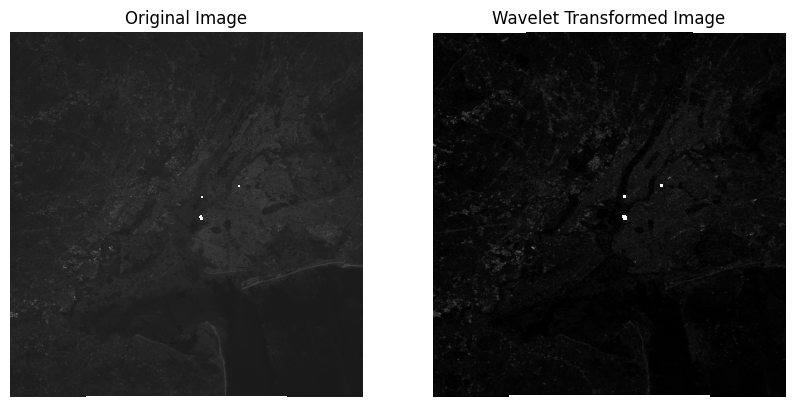

In [22]:
import matplotlib.pyplot as plt

# Create a figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
axs[0].imshow(image[1], cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')  # Hide axis labels

# Display the wavelet transformed image
axs[1].imshow(transformed_image[1], cmap='gray')
axs[1].set_title('Wavelet Transformed Image')
axs[1].axis('off')  # Hide axis labels

plt.show()


In [23]:
import rasterio

# Open the original image to use its metadata for the new image
with rasterio.open('after_image.tif') as src:
    meta = src.meta.copy()  # Copy the metadata

# Update the metadata to reflect the number of bands and data type
# Note: Ensure the data type matches the dtype of your transformed_image
meta.update({
    'dtype': 'float32',  # Set dtype to float32 or another appropriate based on the transformed data
    'count': transformed_image.shape[0]  # Set number of bands
})

# Save the transformed image to a new TIFF file
with rasterio.open('wavelet_transformed_image.tif', 'w', **meta) as dst:
    for i in range(transformed_image.shape[0]):
        dst.write(transformed_image[i, :, :], i + 1)  # Write each band


In [24]:
import geopandas as gpd
import rasterio
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Load the shapefile
gdf = gpd.read_file('training_data_change.shp')

# Convert polygons to centroids if not already points
if gdf.geometry.iloc[0].geom_type != 'Point':
    gdf['geometry'] = gdf.centroid

print(gdf.head())  # Check the centroid coordinates
def extract_values(gdf, raster_path):
    with rasterio.open(raster_path) as src:
        # List to store feature values
        feature_values = []
        # Iterate through each geometry in the dataframe
        for idx, row in gdf.iterrows():
            # Sample raster at the point location
            for val in src.sample([(row.geometry.x, row.geometry.y)]):
                feature_values.append(val)
        return np.array(feature_values)


# Prepare labels
labels = gdf['class'].values  # Replace 'label_column' with the actual name of the label column

# Load and prepare features from both the normal and wavelet-transformed images
features_normal = extract_values(gdf, 'after_image.tif')
features_wavelet = extract_values(gdf, 'wavelet_transformed_image.tif')

# Train and evaluate separate models
rf_normal = RandomForestClassifier(n_estimators=300, random_state=42)
rf_normal.fit(features_normal, labels)

rf_wavelet = RandomForestClassifier(n_estimators=300, random_state=42)
rf_wavelet.fit(features_wavelet, labels)




/tmp/ipykernel_68418/2035457121.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf.centroid


     id  class                    geometry
0  None      4  POINT (-74.21625 40.59812)
1  None      4  POINT (-74.23870 40.56724)
2  None      4  POINT (-74.25324 40.52763)
3  None      2  POINT (-74.13421 40.58292)
4  None      3  POINT (-74.23653 40.60833)


RandomForestClassifier(n_estimators=300, random_state=42)

In [25]:
import rasterio
from sklearn.ensemble import RandomForestClassifier

# Function to read, predict, and save classification for given image path and output path
def classify_and_save(image_path, output_path, model):
    # Read the entire image
    with rasterio.open(image_path) as src:
        # Read all bands and prepare the feature array
        all_bands = src.read()
        num_bands, height, width = all_bands.shape
        all_bands_reshaped = all_bands.reshape(num_bands, height * width).T
        meta = src.meta.copy()  # Copy metadata for saving later

    # Predict the classification for each pixel
    predicted_classes = model.predict(all_bands_reshaped)

    # Reshape the predicted classes back to the original image dimensions
    classified_image = predicted_classes.reshape((height, width))

    # Update metadata for saving the classified image
    meta.update({
        'dtype': 'int32',  # Ensure data type matches the type of `predicted_classes`
        'count': 1  # One band for classified results
    })

    # Save the classified image
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(classified_image, 1)

# Assume 'rf_wavelet' and 'rf_normal' are your trained models for wavelet-transformed and normal images, respectively
wavelet_image_path = 'wavelet_transformed_image.tif'
normal_image_path = 'after_image.tif'

# Classify and save the results for the wavelet-transformed image
classify_and_save(wavelet_image_path, 'classified_wavelet_image.tif', rf_wavelet)

# Classify and save the results for the original image
classify_and_save(normal_image_path, 'classified_normal_image.tif', rf_normal)





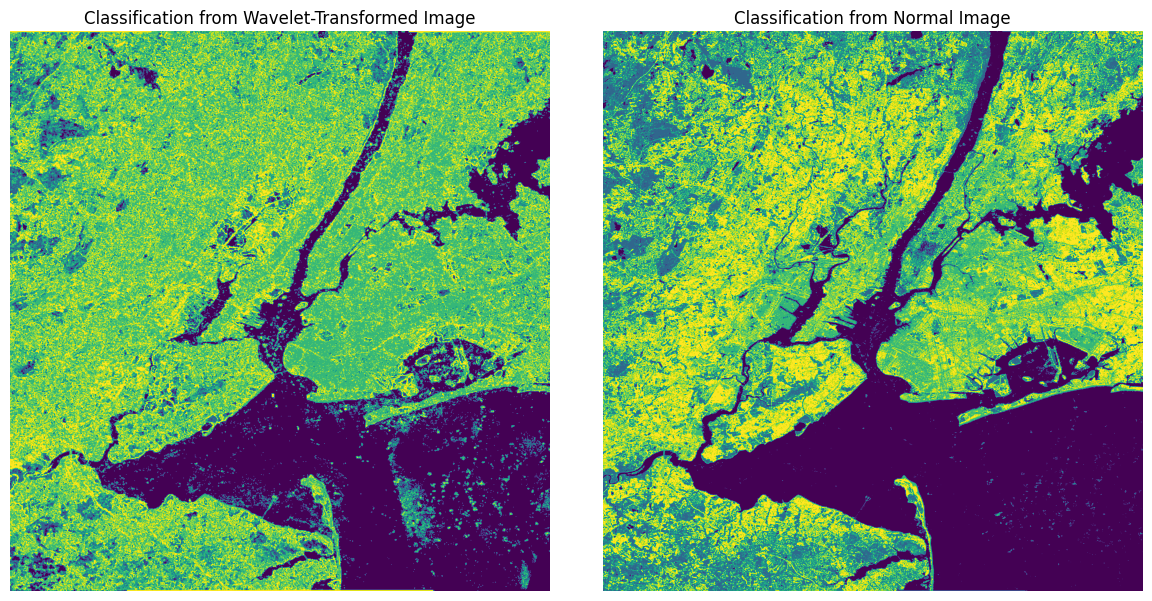

In [26]:
import rasterio
import matplotlib.pyplot as plt

# Function to load a classified image
def load_classified_image(path):
    with rasterio.open(path) as src:
        return src.read(1)  # Read the first band which contains the classification

# Paths to the classified images
classified_wavelet_image_path = 'classified_wavelet_image.tif'
classified_normal_image_path = 'classified_normal_image.tif'

# Load the images
classified_wavelet_image = load_classified_image(classified_wavelet_image_path)
classified_normal_image = load_classified_image(classified_normal_image_path)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust size as needed

# Plot wavelet-transformed classification
axes[0].imshow(classified_wavelet_image, cmap='viridis')  # You can change the colormap as needed
axes[0].set_title('Classification from Wavelet-Transformed Image')
axes[0].axis('off')  # Hide axes

# Plot normal image classification
axes[1].imshow(classified_normal_image, cmap='viridis')
axes[1].set_title('Classification from Normal Image')
axes[1].axis('off')  # Hide axes

# Display the plots
plt.tight_layout()
plt.show()


In [27]:
import geopandas as gpd
import rasterio
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_confusion_matrix(classified_image_path, test_samples_path, reference_column):
    # Load the shapefile containing test samples
    test_samples = gpd.read_file(test_samples_path)

    # Open the classified image to sample from it
    with rasterio.open(classified_image_path) as src:
        # Ensure the CRS matches between the test samples and the raster
        if test_samples.crs != src.crs:
            test_samples = test_samples.to_crs(src.crs)

        # Extract raster values at points
        values = [list(src.sample([(geom.x, geom.y)]))[0][0] for geom in test_samples.geometry]

    # Assuming the shapefile has a column with the true labels
    true_labels = test_samples[reference_column].values

    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, values)

    return cm

# Paths to the classified images
classified_wavelet_image_path = 'classified_wavelet_image.tif'
classified_normal_image_path = 'classified_normal_image.tif'

# Path to the shapefile and the column name with the true labels
test_samples_path = 'change_detection_samples.shp'
reference_column = 'reference'

# Calculate confusion matrices
cm_wavelet = calculate_confusion_matrix(classified_wavelet_image_path, test_samples_path, reference_column)
cm_normal = calculate_confusion_matrix(classified_normal_image_path, test_samples_path, reference_column)

# Print the confusion matrices
print("Confusion Matrix for Wavelet-Transformed Image Classification:")
print(cm_wavelet)
print("Confusion Matrix for Normal Image Classification:")
print(cm_normal)



Confusion Matrix for Wavelet-Transformed Image Classification:
[[37  0  4  4]
 [ 1  8 21 17]
 [ 1  0 31 25]
 [ 0  0 12 13]]
Confusion Matrix for Normal Image Classification:
[[41  1  1  2]
 [ 3 19  2 23]
 [ 2  3 18 34]
 [ 1  0  6 18]]


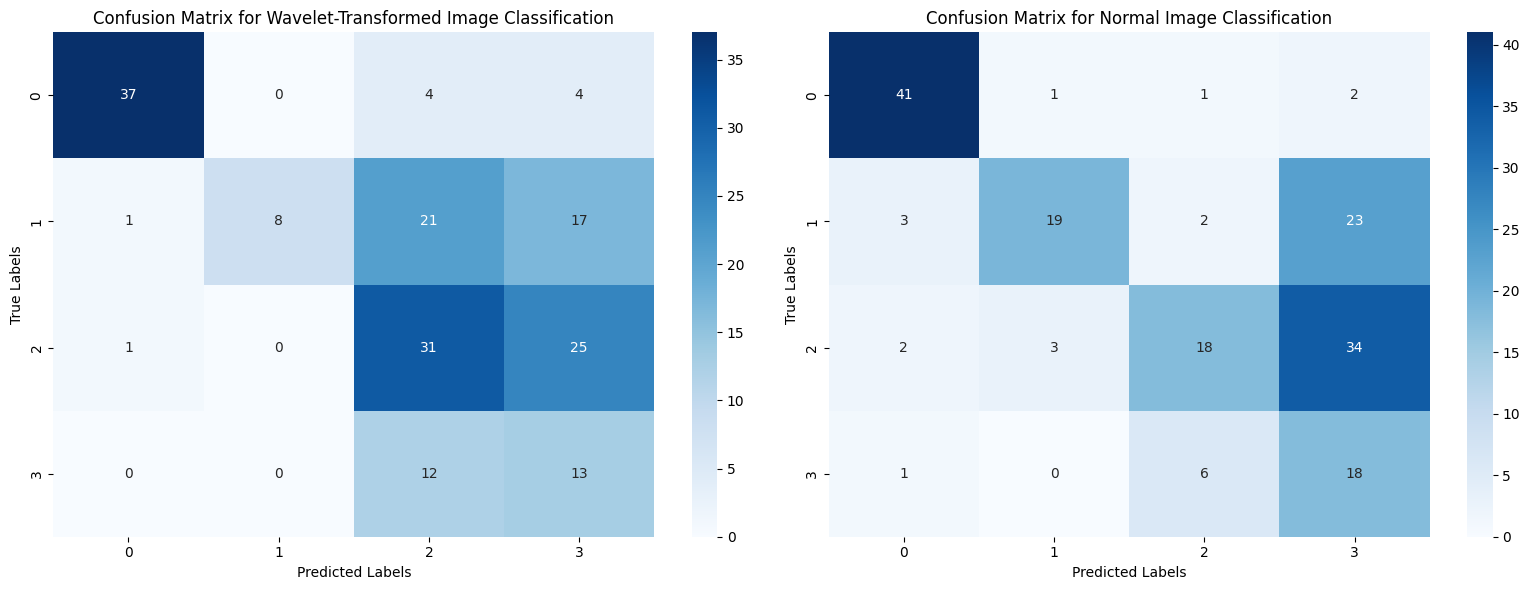

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrices(cm1, cm2, title1='Confusion Matrix 1', title2='Confusion Matrix 2'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Adjust overall figure size as needed

    # Plotting the first confusion matrix
    sns.heatmap(cm1, annot=True, fmt="d", cmap='Blues', xticklabels=True, yticklabels=True, ax=ax1)
    ax1.set_title(title1)
    ax1.set_xlabel('Predicted Labels')
    ax1.set_ylabel('True Labels')

    # Plotting the second confusion matrix
    sns.heatmap(cm2, annot=True, fmt="d", cmap='Blues', xticklabels=True, yticklabels=True, ax=ax2)
    ax2.set_title(title2)
    ax2.set_xlabel('Predicted Labels')
    ax2.set_ylabel('True Labels')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


plot_confusion_matrices(cm_wavelet, cm_normal, 
                        title1='Confusion Matrix for Wavelet-Transformed Image Classification',
                        title2='Confusion Matrix for Normal Image Classification')


